# Problem description

You are to predict whether a company will go bankrupt in the following year, based on financial attributes of the company.

Perhaps you are contemplating lending money to a company, and need to know whether the company
is in near-term danger of not being able to repay.


## Goal

## Learning objectives

- Demonstrate mastery on solving a classification problem and presenting
the entire Recipe for Machine Learning process in a notebook.
- We will make suggestions for ways to approach the problem
    - But there will be little explicit direction for this task.
- It is meant to be analogous to a pre-interview task that a potential employer might assign
to verify your skill

# Import modules

In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline


# API for students

In [2]:
## Load the bankruptcy_helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import bankruptcy_helper module
import bankruptcy_helper
%aimport bankruptcy_helper

helper = bankruptcy_helper.Helper()

# Get the data

The first step in our Recipe is Get the Data.

- Each example is a row of data corresponding to a single company
- There are 64 attributes, described in the section below
- The column `Bankrupt` is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
- The column `Id` is a Company Identifier

In [3]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"

data_file = "5th_yr.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

target_attr = "Bankrupt"

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4818, 66)


## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek

In [4]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.41769,0.0568,1.1605,-126.39,0.41355,0.025417,1.2395,1.16500,0.51773,...,0.049094,0.85835,0.12322,5.6167,7.4042,164.310,2.2214,1.334,0,4510
1,-0.023834,0.2101,0.50839,4.2374,22.034,0.058412,-0.027621,3.6579,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.802,6.4782,0,3537
2,0.030515,0.44606,0.19569,1.565,35.766,0.28196,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.25266,15.049,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.68,438.2,0.13649,0.058164,10.853,1.02790,0.61173,...,0.085524,0.97282,0,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.49712,0.12316,1.3036,-71.398,0,0.001007,1.0116,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.582,114.580,3.1854,2.742,0,1529


Pretty *unhelpful* !

What are these mysteriously named features ?

## Description of attributes

This may still be somewhat unhelpful for those of you not used to reading Financial Statements.

But that's partially the point of the exercise
- You can *still* perform Machine Learning *even if* you are not an expert in the problem domain
    - That's what makes this a good interview exercise: you can demonstrate your thought process even if you don't know the exact meaning of the terms
- Of course: becoming an expert in the domain *will improve* your ability to create better models
    - Feature engineering is easier if you understand the features, their inter-relationships, and the relationship to the target

Let's get a feel for the data
- What is the type of each attribute ?


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   obje

You may be puzzled:
- Most attributes are `object` and *not* numeric (`float64`)
- But looking at the data via `data.head()` certainly gives the impression that all attributes are numeric

Welcome to the world of messy data !  The dataset has represented numbers as strings.
- These little unexpected challenges are common in the real-word
- Data is rarely perfect and clean

So you might want to first convert all attributes to numeric

**Hint**
- Look up the Pandas method `to_numeric`
    - We suggest you use the option `errors='coerce'`
    

# Evaluating your project

We will evaluate your submission on a test dataset that we provide
- It has no labels, so **you** can't use it to evaluate your model, but **we** have the labels
- We will call this evaluation dataset the "holdout" data

Let's get it

In [6]:
holdout_data = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )

print("Data shape: ", holdout_data.shape)


Data shape:  (1092, 65)


We will evaluate your model on the holdout examples using metrics
- Accuracy
- Recall
- Precision

From our lecture: we may have to make a trade-off between Recall and Precision.

Our evaluation of your submission will be partially based on how you made (and described) the trade-off.

You may assume that it is 5 times worse to *fail to identify a company that will go bankrupt*
than it is to fail to identify a company that won't go bankrupt.

# Your model

Time for you to continue the Recipe for Machine Learning on your own.



<html>
<p style="font-size:32px"><strong>1. Data Cleaning</strong></p>
</html>

<html>
<p style="font-size:26px"><strong>1.1 Show the Missing Data</strong></p>
</html>

From the table below, we can see that there are lots of "?" in the dataset. So let us apply the to_numeric function in pandas to convert all the numbers and strings into float.

In [7]:
data[data["X8"].eq("?")]

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
466,0,0,0.44915,?,6792.3,0,0,?,1.825800,0.54961,...,0,0.54771,0,2.2926,0.11672,0.0,?,0.89252,0,3007
577,-463.89,0,0,?,0,-463.89,-463.89,?,0.871600,266.86,...,-1.7384,1.14730,0,6.9498,?,0.0,?,28999,1,4575
655,0,0,0.36932,?,-3227.9,0,0,?,0.635900,0.70944,...,0,1.57260,0,-12.44,-0.092493,0.0,?,-3.7265,0,3724
1756,0.005403,0,1,?,0,0,0.006683,?,0.044334,1,...,0.005403,0.93883,0,0.063232,?,0.0,?,?,0,2035
1974,0.14394,0,0.41299,?,63.962,0.30062,0.14394,?,1.068600,0,...,?,0.93582,?,22.667,9.014,0.0,?,3.3814,0,3962
2000,0.79823,0,1,?,126.55,-1.0582,0.90137,?,3.745900,1,...,0.79823,0.75939,0,?,16.293,0.0,?,?,0,2050
2690,0.29175,0,0.90259,?,37.089,-0.30642,0.36006,?,8.888500,1,...,0.29175,0.96089,0,?,21.597,0.0,?,91.252,0,1383
2999,0.7983,0,1,?,126.54,-1.0581,0.90144,?,3.745900,1,...,0.7983,0.75938,0,?,16.288,0.0,?,?,1,3973
3172,0,0,1.3854,?,8424.7,0,0,?,1.472400,4.1294,...,0,0.67918,0,0.6308,0.08221,0.0,?,0.27858,0,3797
3328,0,0,17.631,?,10273,0,0,?,1.278400,21.653,...,0,0.78224,0,4.3072,0.073551,0.0,?,0.42187,0,2902


In [8]:
len(data)

4818

In [9]:
clean_data = data.copy(deep = True)

In [10]:
for i in range(len(data)):
    clean_data.loc[i] = pd.to_numeric(data.loc[i] ,errors = "coerce")

In [11]:
clean_dropna_data = clean_data.dropna()

In [12]:
len(clean_dropna_data)

2474

We set the parameter errors equal to coerce in order to convert all the "?" to Nan. Then we drop the Nan in the dataset and get a new one clean_dropna_data.

Although the dataset is clean right now with all the float value, it does not mean that we can use it without concerns. After dropping Nan, we have thrown away half the dataset which is unacceptablt. We need to do something to rescue our missing dataset.

<html>
<p style="font-size:26px"><strong>1.2 Missing Data Analysis</strong></p>
</html>

First of all, we want to see where is the missing value located in our dataset. We generate Sparsity Matrix to visualize it.

In [13]:
for i in range(len(data)):
    clean_data.loc[i] = pd.to_numeric(clean_data.loc[i])

In [14]:
clean_data = clean_data.astype("float")

Right now I am going to use a package that is not included in the anaconda, called missingno. It is useful for analyzing the missing value as well as the relationship betweenthe presence or absence of missing value. It is helpful since it can draw a map and show us the situation of missing value directly.

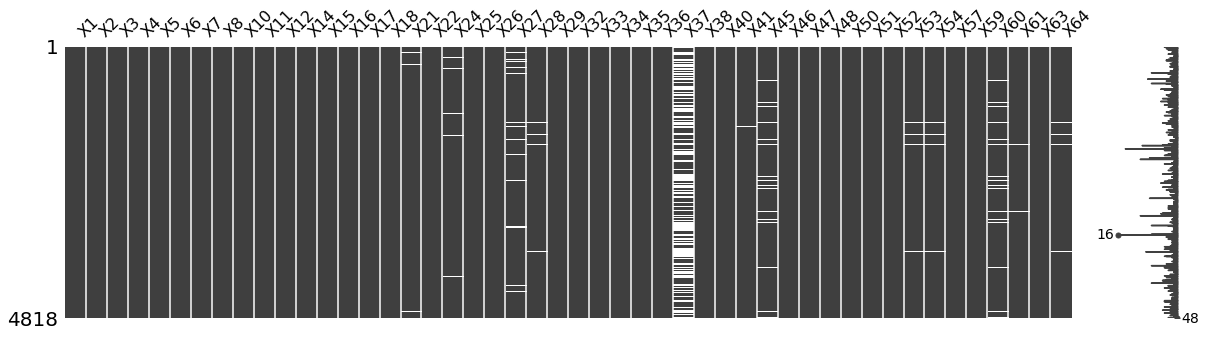

In [15]:
#!pip install missingno
import missingno as msno
missing_data = clean_data.columns[clean_data.isna().any()].tolist()
msno.matrix(clean_data[missing_data],figsize=(20,5))

As we can see, the missing data are concentrated in column X37. Although I really want to throw this column away immediately, I chose to tolerate it and see what can I do to replace it. In order to fill in those Nan, I am trying to see whether there is some other relation between X37 and other columns.

After Googling, a Heat Map can guide us through how to deal with these data.

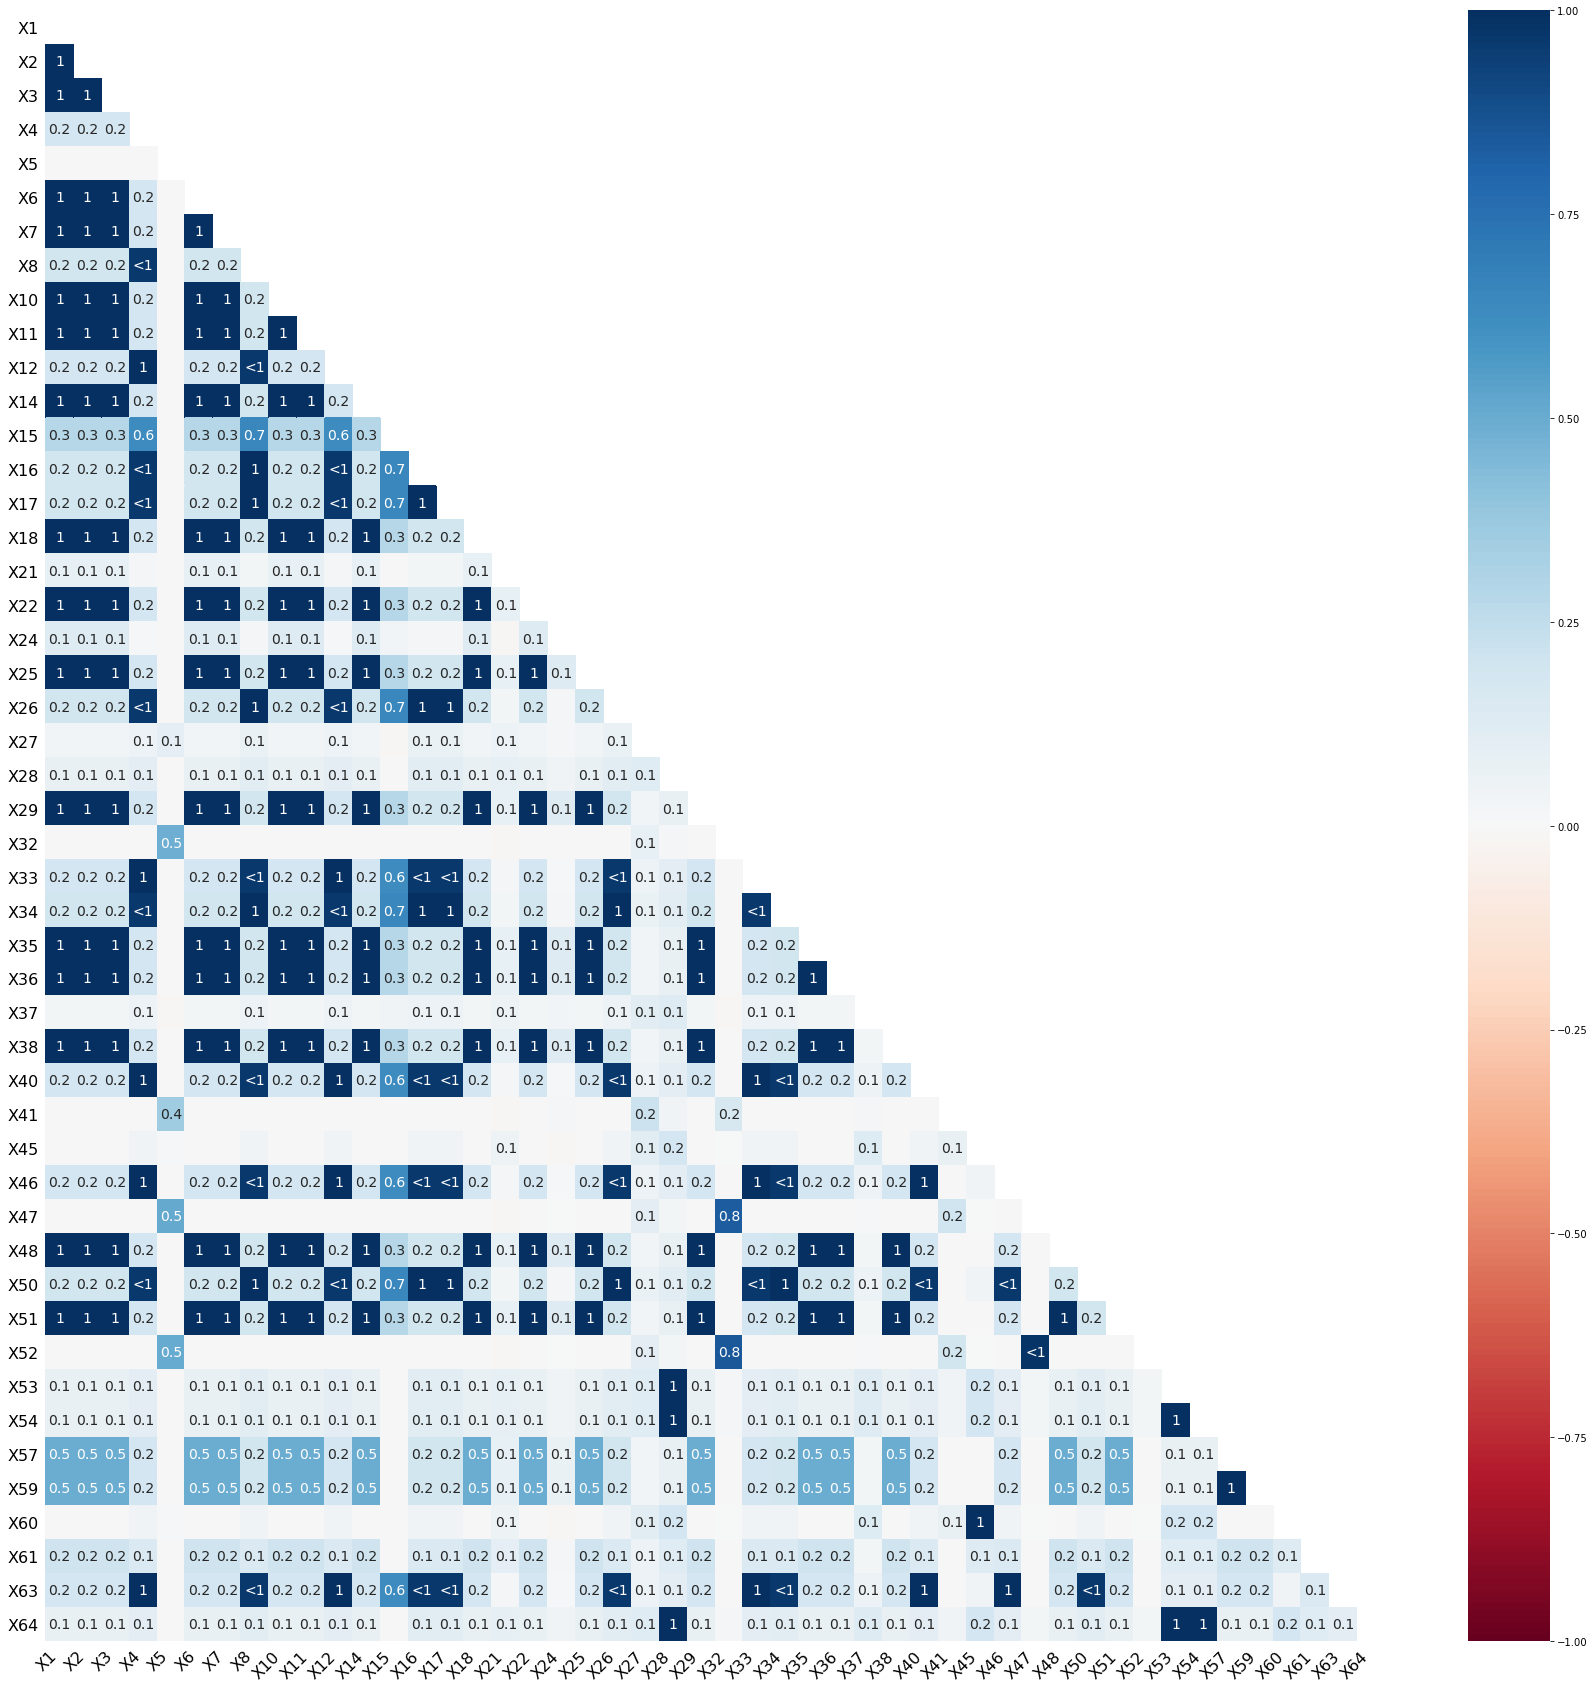

In [16]:
msno.heatmap(clean_data[missing_data],figsize = (30,30))

The heatmap mearsures nullity correlation, which means how strongly the variable affects the presence of another. 

-1 means one variable appears and the other definitely does not

0 means variable's presence have no effect on one another

1 means if one variable appears then the ohter definitely does

We can see that some variables' presences are strongly correlated to others, so this gives a hint to us that some blank can be filled after computation. However, column X37 has no obvious relation to others. We decide to delete the column.

In [17]:
clean_data_drop = clean_data.drop(["X37"],axis = 1)

In [18]:
clean_data_dropna = clean_data_drop.dropna()

In [19]:
clean_data_dropna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4087 entries, 0 to 4817
Data columns (total 65 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4087 non-null   float64
 1   X2        4087 non-null   float64
 2   X3        4087 non-null   float64
 3   X4        4087 non-null   float64
 4   X5        4087 non-null   float64
 5   X6        4087 non-null   float64
 6   X7        4087 non-null   float64
 7   X8        4087 non-null   float64
 8   X9        4087 non-null   float64
 9   X10       4087 non-null   float64
 10  X11       4087 non-null   float64
 11  X12       4087 non-null   float64
 12  X13       4087 non-null   float64
 13  X14       4087 non-null   float64
 14  X15       4087 non-null   float64
 15  X16       4087 non-null   float64
 16  X17       4087 non-null   float64
 17  X18       4087 non-null   float64
 18  X19       4087 non-null   float64
 19  X20       4087 non-null   float64
 20  X21       4087 non-null   floa

So right now, besides the X37 columns, we also throw away 800 rows data.

Since we are trying to make the most optimized model, we decide to make additional manipulation on the data before dropna but after drop X37. We should use imputer from sklearn and choose "mean" and "median" method in order to compare the performance of this three groups of data.

In [20]:
from sklearn.impute import SimpleImputer
Imp_mean = SimpleImputer(missing_values = np.nan, strategy="mean")
Imp_mean_df = pd.DataFrame(Imp_mean.fit_transform(clean_data_drop))

Imp_mean_df.columns = clean_data_drop.columns

In [21]:
Imp_median = SimpleImputer(missing_values = np.nan, strategy="median")
Imp_median_df = pd.DataFrame(Imp_median.fit_transform(clean_data_drop))

Imp_median_df.columns = clean_data_drop.columns

Try Nearest neighbors imputation too, lets see which is the best.

In [22]:
from sklearn.impute import KNNImputer
Imp_KNN = KNNImputer(n_neighbors = 100, weights = "uniform")
Imp_KNN_df = pd.DataFrame(Imp_KNN.fit_transform(clean_data_drop))

Imp_KNN_df.columns = clean_data_drop.columns


# 1.3 checking data unbalance

In [23]:
import matplotlib.pyplot as plt
data_df = clean_data_dropna
temp = data_df["Bankrupt"].value_counts()
df = pd.DataFrame({"Class":temp.index, "values":temp.values})

Text(0.5, 1.0, 'Brankrupt unbalanced data')

<ipython-input-24-8340b77ab335>:3: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.bar(df["Class"], df["values"], color = "rb", tick_label=labels)


<BarContainer object of 2 artists>

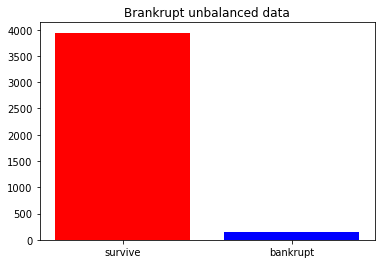

In [24]:
plt.title("Brankrupt unbalanced data")
labels = ["survive", "bankrupt"]
plt.bar(df["Class"], df["values"], color = "rb", tick_label=labels)

Just pick the dropna data and see what is going on in it. The data is very imbalance and need some adjustments. There is another package called "imblearn", is used to oversample data.

In [25]:
#!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

SMOTE stands for Synthetic Minority Oversampling TEchnique, which selects examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

However, we must oversample the data after train test split. See imblearn in later section.

# 2 PCA

In [26]:
import seaborn as sns

<Figure size 1440x1440 with 0 Axes>

Text(0.5, 1.0, 'Bankrupt feature correlation plot')

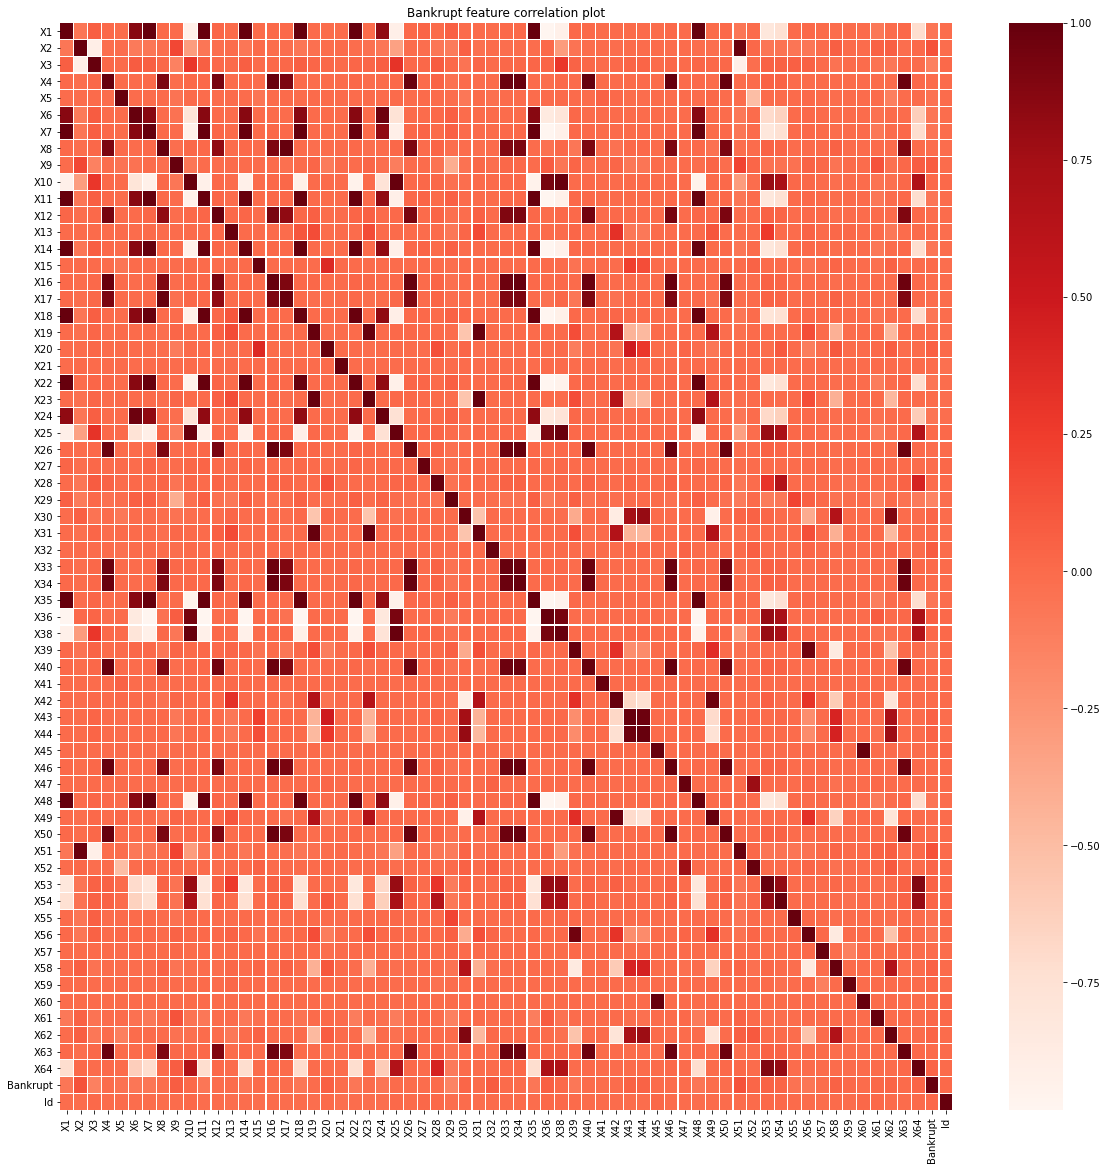

In [27]:
plt.figure(figsize = (20, 20))
plt.title('Bankrupt feature correlation plot')
corr = clean_data_drop.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=0.1, cmap="Reds")
plt.show()

We use the heatmap to present the correlation between each feature. The darker the color, the stronger the correlation is. Since the diagnol line represents the correlation equals to 1, we can also find that there are lots of features having strong relation with others. On my first glance, it is neccesary for us to use PCA to reduce the dimension of this data. However, when we analyze the dark square of the model like (X17, X63), (X33, X50), we find that:

Text(0.5, 1.0, 'X17 vs X63')

Text(0.5, 0, 'X17')

Text(0, 0.5, 'X63')

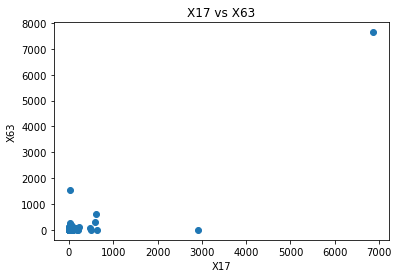

In [28]:
plt.title("X17 vs X63")
plt.scatter(clean_data_drop["X17"], clean_data_drop["X63"])
plt.xlabel("X17")
plt.ylabel("X63")
plt.show()

There is an outlier that make the relation between columns look like linear correlation! Once we drop the outlier, we can see that:

Text(0.5, 1.0, 'X17 vs X63 outlier dropped')

Text(0.5, 0, 'X17')

Text(0, 0.5, 'X63')

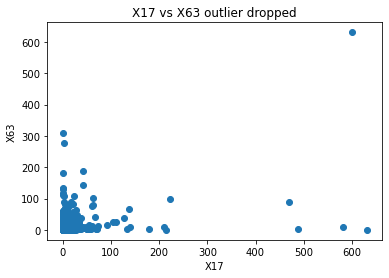

In [29]:
x = list(clean_data_drop["X17"])
y = list(clean_data_drop["X63"])
x.remove(max(x))
x.remove(max(x))
y.remove(max(y))
y.remove(max(y))
plt.title("X17 vs X63 outlier dropped")
plt.scatter(x, y)
plt.xlabel("X17")
plt.ylabel("X63")
plt.show()

Obviously, the data has little correlation between each other. Same things happen to nearly all the data. So we are not going to use PCA.

And we are going to use random forset model which is a selection model, so feature scaling is not necessary.

# 3 Model Selection

In [30]:
global rs 

rs = 42 #random_state

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline, make_pipeline
#from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_precision_recall_curve
import warnings;
warnings.simplefilter('ignore')

In [32]:
def getScores(estimator, x, y):
    yPred = estimator.predict(x)
    return(accuracy_score(y, yPred), 
           precision_score(y, yPred, pos_label=3, average='macro'),
           recall_score(y,yPred,pos_label=3,average='macro'))

def my_scorer(estimator,x,y):
    a, p, r = getScores(estimator, x, y)
    print(a, p, r)
    return a+p+r

def model_select(df):
    models = [GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier()]
    names = ["Naive Bayes","Decision Tree","Random Forest"]
    
    features = df.iloc[:,:-2]
    target = df.iloc[:,-2]
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.1, random_state = rs)
    
    for model, name in zip(models, names):
        print(name)
        m = cross_val_score(model, X_train, y_train, scoring = my_scorer, cv=5).mean()
        print('\nSum:',m, '\n\n')
    return X_train, X_test, y_train, y_test

In [33]:
X_train_dropna, X_test_dropna, y_train_dropna, y_test_dropna = model_select(clean_data_dropna)

Naive Bayes
0.17119565217391305 0.5041030248577418 0.5148429035752979
0.12907608695652173 0.4782301385354821 0.4374322860238353
0.3016304347826087 0.504516317016317 0.5268689057421452
0.25170068027210885 0.5178559886238769 0.5933802816901408
0.745578231292517 0.5359461966604824 0.713943661971831

Sum: 1.3852601580349642 


Decision Tree
0.9524456521739131 0.6473417721518987 0.6418743228602384
0.9456521739130435 0.6115819209039548 0.6198266522210184
0.9442934782608695 0.6072525971809003 0.6191224268689057
0.9605442176870749 0.6933252581920184 0.6708450704225353
0.9496598639455782 0.5996111181945684 0.5880281690140845

Sum: 2.21028093879812 


Random Forest
0.967391304347826 0.8182648401826484 0.5755146262188515
0.9660326086956522 0.8169622555707139 0.5377573131094258
0.9605978260869565 0.6263962375073486 0.5349404117009751
0.9714285714285714 0.9856361149110807 0.58
0.9687074829931973 0.8599521203830369 0.5592957746478873

Sum: 2.3457754975568346 




In [34]:
X_train_KNN, X_test_KNN, y_train_KNN, y_test_KNN = model_select(Imp_KNN_df)

Naive Bayes
0.1313364055299539 0.5170462387853693 0.5193335569719334
0.11764705882352941 0.49504030452306313 0.49504030452306313
0.12802768166089964 0.508104588258866 0.5090573219883565
0.11764705882352941 0.49504030452306313 0.49504030452306313
0.11764705882352941 0.49504030452306313 0.49504030452306313

Sum: 1.1272177593608692 


Decision Tree
0.9147465437788018 0.640881136084088 0.640881136084088
0.9181084198385236 0.6537857045237119 0.6511755485893417
0.9158016147635525 0.6675210611220649 0.709270040304523
0.9019607843137255 0.5901774704949797 0.5917039856695029
0.9158016147635525 0.6569224604287718 0.6753694581280788

Sum: 2.208821395777462 


Random Forest
0.9447004608294931 0.8582995951417004 0.5890640724589065
0.9388696655132641 0.7448550260678679 0.6198835647111509
0.9388696655132641 0.7472834857450241 0.6029332736229288
0.9400230680507498 0.7676470588235293 0.5865987460815048
0.9423298731257209 0.8192217618447126 0.5793551276309897

Sum: 2.3239868890321618 




In [35]:
X_train_median, X_test_median, y_train_median, y_test_median = model_select(Imp_median_df)

Naive Bayes
0.14170506912442396 0.5124753216692763 0.5163927093816393
0.12341407151095732 0.4982651796778191 0.4981191222570533
0.12572087658592848 0.5072180916976455 0.5078257948947604
0.12341407151095732 0.4982651796778191 0.4981191222570533
0.11764705882352941 0.5036391451485791 0.5035154500671742

Sum: 1.1351472528569233 


Decision Tree
0.9101382488479263 0.6334328722042781 0.6468970144246897
0.9284890426758939 0.7007797270955165 0.7075682937751904
0.9158016147635525 0.6597622198007471 0.6838446036721899
0.9146482122260668 0.6370358351490427 0.6323779668607254
0.9204152249134948 0.6501615209447651 0.6269816390506046

Sum: 2.2336668072809367 


Random Forest
0.9412442396313364 0.822027972027972 0.5617913451861791
0.9388696655132641 0.7440192405925421 0.6283587102552619
0.9423298731257209 0.7800587265608903 0.621730855351545
0.9411764705882353 0.7860605170387779 0.5872145096283027
0.9434832756632064 0.8307653659353542 0.5884460367218988

Sum: 2.3315153607640973 




In [36]:
X_train_mean, X_test_mean, y_train_mean, y_test_mean = model_select(Imp_median_df)

Naive Bayes
0.14170506912442396 0.5124753216692763 0.5163927093816393
0.12341407151095732 0.4982651796778191 0.4981191222570533
0.12572087658592848 0.5072180916976455 0.5078257948947604
0.12341407151095732 0.4982651796778191 0.4981191222570533
0.11764705882352941 0.5036391451485791 0.5035154500671742

Sum: 1.1351472528569233 


Decision Tree
0.9158986175115207 0.6439393939393939 0.6414961422341496
0.9261822376009228 0.6913905133203379 0.6978616211374832
0.9215686274509803 0.6819201995012469 0.7123488580385132
0.9111880046136102 0.6241629082957496 0.6220555306762203
0.9273356401384083 0.6912930627654554 0.6815270935960591

Sum: 2.25803369016401 


Random Forest
0.9389400921658986 0.7581967213114754 0.5690372358269037
0.9446366782006921 0.7921957671957672 0.6483878190774742
0.9423298731257209 0.7800587265608903 0.621730855351545
0.9469434832756632 0.8747652582159624 0.607243618450515
0.9434832756632064 0.8307653659353542 0.5884460367218988

Sum: 2.3574321614157934 




These are tests that implement 3 different model: Gaussian Naive Bayes, Decicion Tree and Random Forest. We first look at them without oversampling in four different missing data methods. From the cross valuation result above, we can see that the random forest model has the highest score and the mean imputation has the best performance.

Then, we are going to test the model using oversampling method SMOTE from imblearn and let's see what it will be.

In [37]:
def model_select_imb(df):
    models = [GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier()]
    names = ["Naive Bayes","Decision Tree","Random Forest"]
    
    features = df.iloc[:,:-2]
    target = df.iloc[:,-2]
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.1, random_state = rs)
    
    
    for model, name in zip(models, names):
        print(name)
        imba_pipeline = make_pipeline(SMOTE(), model)
        m = cross_val_score(imba_pipeline, X_train, y_train, scoring = my_scorer, cv=5).mean()
        print('\nSum:',m, '\n\n')
    return X_train, X_test, y_train, y_test

In [38]:
X_train, X_test, y_train, y_test = model_select_imb(Imp_mean_df)

Naive Bayes
0.12672811059907835 0.5158073369508286 0.5168735323716873
0.12110726643598616 0.4893122676579926 0.48841244961934616
0.12687427912341406 0.499970386164416 0.49996641289744737
0.11764705882352941 0.49504030452306313 0.49504030452306313
0.11418685121107267 0.5115231990231991 0.5101433049708912

Sum: 1.1257266129790031 


Decision Tree
0.9112903225806451 0.6491176470588236 0.6814156323381415
0.8985005767012687 0.6546092598816018 0.7678347514554411
0.8961937716262975 0.6466422032828283 0.7496529332736229
0.9100346020761245 0.6647790140152446 0.7400918047469771
0.895040369088812 0.631981981981982 0.7066614420062696

Sum: 2.280769262422816 


Random Forest
0.9504608294930875 0.807487922705314 0.7277535502627753
0.9296424452133795 0.7047186013739651 0.7081840573219883
0.9446366782006921 0.7683823529411764 0.750089565606807
0.9400230680507498 0.7478603792582648 0.764576802507837
0.9423298731257209 0.7576143896898614 0.7488580385132109

Sum: 2.4385237108529663 




The result of SMOTE oversampling method is better than the original one, let's train a model and see what is going on in the test set.

In [39]:
features = Imp_mean_df.iloc[:,:-2]
target = Imp_mean_df.iloc[:,-2]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.1, random_state = rs)

X_train_res, y_train_res = SMOTE().fit_sample(X_train, y_train)

rfc_res = RandomForestClassifier()
rfc_res.fit(X_train_res, y_train_res)

RandomForestClassifier()

In [40]:
y_pred_res = rfc_res.predict(X_test)

In [41]:
accuracy_res = accuracy_score(y_test, y_pred_res)
precision_res = precision_score(y_test, y_pred_res)
recall_res = recall_score(y_test, y_pred_res)

In [42]:
print("accuracy:" ,accuracy_res)
print("precision:" ,precision_res)
print("recall:" ,recall_res)

accuracy: 0.9315352697095436
precision: 0.5
recall: 0.48484848484848486


Text(0.5, 1.0, 'rfc + oversample ')

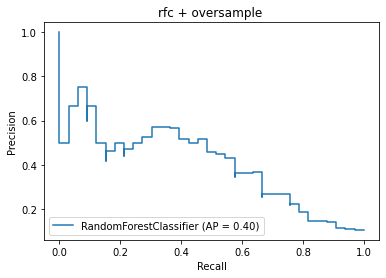

In [43]:
disp = plot_precision_recall_curve(rfc_res, X_test, y_test)
disp.ax_.set_title('rfc + oversample ')

Well, maybe the result is not satisfied. Let's see the model without SMOTE.

In [44]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [45]:
y_pred = rfc.predict(X_test)

In [46]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [47]:
print("accuracy:" ,accuracy)
print("precision:" ,precision)
print("recall:" ,recall)

accuracy: 0.9522821576763485
precision: 0.8571428571428571
recall: 0.36363636363636365


The precision is improved but recall is worse. Maybe we should focus on the parameter of Random Forest.

In [48]:
rfc_grid = RandomForestClassifier()
params = {
    'n_estimators':[30, 50, 100, 200],
    'max_depth':[4,6,10,12]
}
grid_rfc = GridSearchCV(rfc_grid, param_grid=params, cv=5, scoring = 'recall').fit(X_train, y_train)
grid_rfc.best_score_

0.34909090909090906

In [49]:
y_pred_grid = grid_rfc.predict(X_test)

In [50]:
grid_rfc.best_params_

{'max_depth': 12, 'n_estimators': 30}

Text(0.5, 1.0, 'Grid but not oversample ')

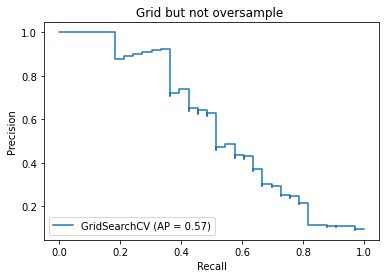

In [51]:
disp = plot_precision_recall_curve(grid_rfc, X_test, y_test)
disp.ax_.set_title('Grid but not oversample ')

Then let us look at the SMOTE data:

In [52]:
features = Imp_mean_df.iloc[:,:-2]
target = Imp_mean_df.iloc[:,-2]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.1, random_state = rs)

X_train_res, y_train_res = SMOTE().fit_sample(X_train, y_train)

rfc = RandomForestClassifier()
grid_res = GridSearchCV(rfc_grid, param_grid=params, cv=5, scoring = 'recall').fit(X_train_res, y_train_res)
grid_res.best_score_

0.9862096231799755

In [53]:
grid_res.best_params_

{'max_depth': 12, 'n_estimators': 200}

Text(0.5, 1.0, 'Grid & oversample ')

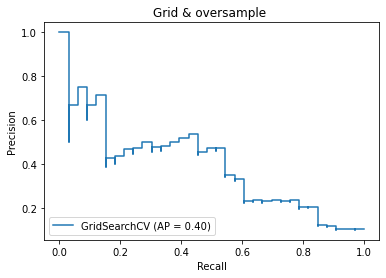

In [54]:
disp = plot_precision_recall_curve(grid_res, X_test, y_test)
disp.ax_.set_title('Grid & oversample ')

In [55]:
grid_res_precision = GridSearchCV(rfc_grid, param_grid=params, cv=5, scoring = 'precision').fit(X_train_res, y_train_res)
grid_res_precision.best_score_

0.9533927711450438

In [56]:
grid_res_precision.best_params_

{'max_depth': 12, 'n_estimators': 30}

So the best model is Random Forest with n_estimator = 100 and max_depth = 12.

# 4 Feautures importance

<Figure size 1080x1080 with 0 Axes>

Text(0.5, 1.0, 'Features importance')

[Text(0, 0, 'X27'),
 Text(0, 0, 'X6'),
 Text(0, 0, 'X38'),
 Text(0, 0, 'X35'),
 Text(0, 0, 'X22'),
 Text(0, 0, 'X54'),
 Text(0, 0, 'X40'),
 Text(0, 0, 'X15'),
 Text(0, 0, 'X26'),
 Text(0, 0, 'X25'),
 Text(0, 0, 'X16'),
 Text(0, 0, 'X29'),
 Text(0, 0, 'X1'),
 Text(0, 0, 'X45'),
 Text(0, 0, 'X21'),
 Text(0, 0, 'X34'),
 Text(0, 0, 'X41'),
 Text(0, 0, 'X60'),
 Text(0, 0, 'X18'),
 Text(0, 0, 'X11'),
 Text(0, 0, 'X13'),
 Text(0, 0, 'X37'),
 Text(0, 0, 'X10'),
 Text(0, 0, 'X24'),
 Text(0, 0, 'X63'),
 Text(0, 0, 'X50'),
 Text(0, 0, 'X59'),
 Text(0, 0, 'X9'),
 Text(0, 0, 'X55'),
 Text(0, 0, 'X23'),
 Text(0, 0, 'X53'),
 Text(0, 0, 'X28'),
 Text(0, 0, 'X12'),
 Text(0, 0, 'X43'),
 Text(0, 0, 'X47'),
 Text(0, 0, 'X2'),
 Text(0, 0, 'X14'),
 Text(0, 0, 'X3'),
 Text(0, 0, 'X44'),
 Text(0, 0, 'X17'),
 Text(0, 0, 'X52'),
 Text(0, 0, 'X36'),
 Text(0, 0, 'X57'),
 Text(0, 0, 'X19'),
 Text(0, 0, 'X58'),
 Text(0, 0, 'X5'),
 Text(0, 0, 'X20'),
 Text(0, 0, 'X49'),
 Text(0, 0, 'X46'),
 Text(0, 0, 'X56'),
 Text(

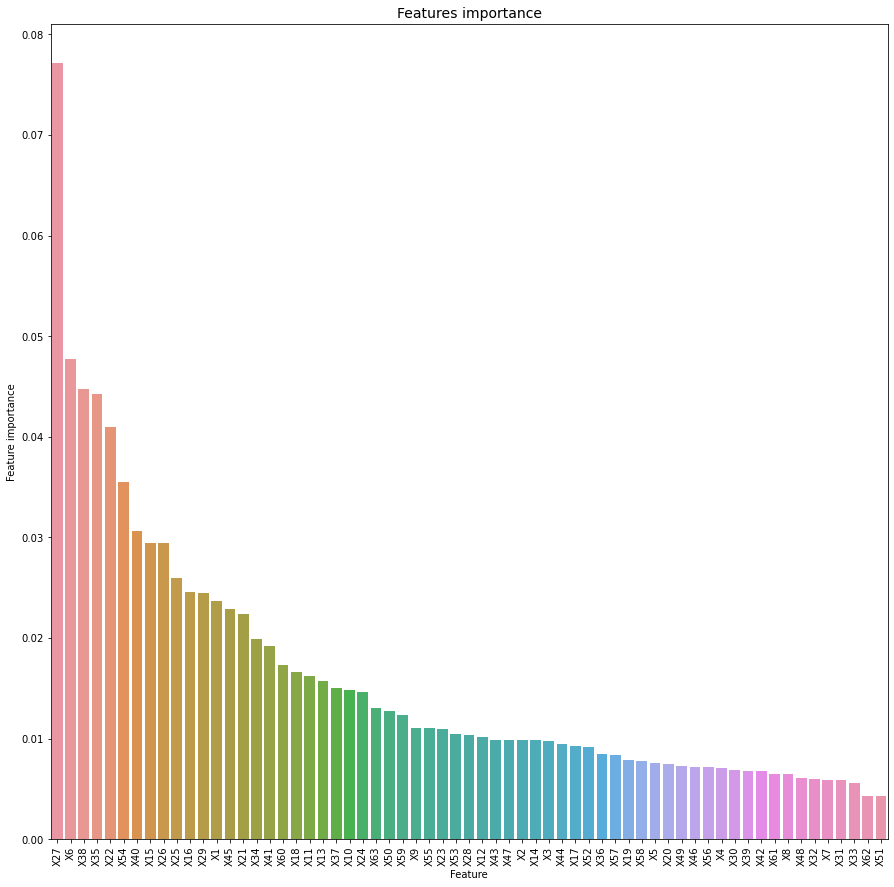

In [76]:
tmp = pd.DataFrame({'Feature':data.iloc[:,:-3].columns, 'Feature importance':rfc_res.feature_importances_})
tmp = tmp.sort_values(by='Feature importance', ascending=False)
plt.figure(figsize=(15,15))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x = 'Feature', y='Feature importance',data = tmp)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.show()

We can see that the most importance features are X27:profit on operating activities / financial expenses, X6:retained earnings / total assets, X38:constant capital / total assets, which are quite make sense.

## Submission guidelines

Although your notebook may contain many models (e.g., due to your iterative development)
we will only evaluate a single model.
So choose one (explain why !) and do the following.

- You will implement the body of a subroutine `MyModel`
    - That takes as argument a Pandas DataFrame 
        - Each row is an example on which to predict
        - The features of the example are elements of the row
    - Performs predictions on each example
    - Returns an array or predictions with a one-to-one correspondence with the examples in the test set
    

We will evaluate your model against the holdout data
- By reading the holdout examples `X_hold` (as above)
- Calling `y_hold_pred = MyModel(X_hold)` to get the predictions
- Comparing the predicted values `y_hold_pred` against the true labels `y_hold` which are known only to the instructors

See the following cell as an illustration

**Remember**

The holdout data is in the same format as the one we used for training
- Except that it has no attribute for the target
- So you will need to perform all the transformations on the holdout data
    - As you did on the training data
    - Including turning the string representation of numbers into actual numeric data types

All of this work *must* be performed within the body of the `MyModel` routine you will write

We will grade you by comparing the predictions array you create to the answers known to us.

In [62]:

import pandas as pd
import os
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


def MyModel(X):
    # It should create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    
    # YOUR CODE GOES HERE
    
    #make those string type data numerial
    clean_data = data.copy(deep = True)
    for i in range(len(data)):
        clean_data.loc[i] = pd.to_numeric(data.loc[i] ,errors = "coerce")
#     for i in range(len(clean_data)):
#         clean_data.loc[i] = pd.to_numeric(clean_data.loc[i])
    clean_data = clean_data.astype("float")
    
    #drop column X37
    clean_data_drop = clean_data.drop(["X37"],axis = 1)
    
    #impute missing data using mean method
    Imp_mean = SimpleImputer(missing_values = np.nan, strategy="mean")
    Imp_mean_df = pd.DataFrame(Imp_mean.fit_transform(clean_data_drop))
    Imp_mean_df.columns = clean_data_drop.columns
    features = Imp_mean_df.iloc[:,:-1]

    #training set
    features = Imp_mean_df.iloc[:,:-2]
    target = Imp_mean_df.iloc[:,-2]
    
    #Oversample
    X_train_res, y_train_res = SMOTE().fit_sample(features, target)
    
    #Random Forest 
    rfc_grid = RandomForestClassifier()
    params = {
        'n_estimators':[30, 50, 100, 200],
        'max_depth':[4,6,10,12]
    }

    #GridSearchCV
    grid_res = GridSearchCV(rfc_grid, param_grid=params, cv=5, scoring = 'recall').fit(X_train_res, y_train_res)
    
    #repeat the steps above to predict X
    #make those string type data numerial
    clean_X = X.copy(deep = True)
    for i in range(len(X)):
        clean_X.loc[i] = pd.to_numeric(X.loc[i] ,errors = "coerce")
#     for i in range(len(X)):
#         clean_X.loc[i] = pd.to_numeric(clean_X.loc[i])
    clean_X = clean_X.astype("float")
    
    #drop column X37
    clean_X_drop = clean_X.drop(["X37"],axis = 1)
    
    #impute missing data using mean method
    Imp_mean_X = SimpleImputer(missing_values = np.nan, strategy="mean")
    Imp_mean_X = pd.DataFrame(Imp_mean_X.fit_transform(clean_X_drop))
    Imp_mean_X.columns = clean_X_drop.columns
    features_X = Imp_mean_X.iloc[:,:-1]
    
    predictions = grid_res.predict(features_X)
    
    return predictions



# Check your work: predict and evaluate metrics on *your* test examples

Although only the instructors have the correct labels for the holdout dataset, you may want
to create your own test dataset on which to evaluate your out of sample metrics.

If you choose to do so, you can evaluate your models using the same metrics that the instructors will use.

- Test whether your implementation of `MyModel` works
- See the metrics  your model produces

In [63]:
name = "Choose a descriptive name for your model"
features = data.iloc[:,:-2]
target = data.iloc[:,-2]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.1, random_state = 42)
X_hold = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )
y_test_pred = MyModel(X_hold)

accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred, pos_label=1, average="binary")
precision_test = precision_score(y_test,   y_test_pred, pos_label=1, average="binary")

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            )
         )

# Citation

https://github.com/ResidentMario/missingno

https://www.kaggle.com/gpreda/credit-card-fraud-detection-predictive-models

https://github.com/smaddikonda/

https://scikit-learn.org/stable/modules/impute.html